# Mind Model

## 0. Import Libraries

### 0.1 Standard Library

In [2]:
import gc
import importlib
import os
import random
import shutil
from typing import Any

### 0.2 External Libraries

In [3]:
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import BatchNormalization, concatenate, Conv2D, Conv2DTranspose, Dropout, Input, MaxPooling2D
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, BinaryIoU, Precision, Recall
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.src.engine.keras_tensor import KerasTensor
from keras.utils import Sequence
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf

2024-01-16 17:03:07.121516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 17:03:07.121717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 17:03:07.146960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 17:03:07.345220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 17:03:09.394097: W tensorflow/compiler/tf2

## 1. Setup

### 1.1 Check and Configure Google Colab

In [5]:
WORKDIR_PATH = "../"
try:
    google_module = importlib.import_module("google.colab.drive")
    DRIVE_PATH = "/content/drive/"
    getattr(google_module, "mount")(DRIVE_PATH)
    WORKDIR_PATH = DRIVE_PATH + "MyDrive/POPBL 5/Modeloa/colab/"
except ImportError:
    pass

### 1.2 Set Global Constants

In [6]:
DATASET_DIR = WORKDIR_PATH + "dataset/"
MODEL_DIR = WORKDIR_PATH + "src/mind/model/"
MODEL_NAME = "mind.keras"

### 1.3 Setup the GPU

#### 1.3.1 Set Max VRAM Size

In [7]:
VRAM = 2048 # Google Colab Free Tier = 15360, Eñaut = 2048, Txillu = 8192, Gaizka = 16376

#### 1.3.2 Configure VRAM Usage

Attempts to allocate only as much GPU memory as needed for the runtime allocations: it starts out allocating very little memory, and as the program gets run and more GPU memory is needed, the GPU memory region is extended for the TensorFlow process. The GPU memory is limited by the constant `VRAM`

In [8]:
GPU_LIST = tf.config.list_physical_devices("GPU")
if GPU_LIST:
    try:
        for gpu in GPU_LIST:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=VRAM)])
        logical_gpu_list = tf.config.list_logical_devices("GPU")
        print(f"Available GPUs: {len(GPU_LIST)} Physical GPUs, {len(logical_gpu_list)} Logical GPUs")
    except RuntimeError as e:
        print(f"Error: {e}")

Available GPUs: 1 Physical GPUs, 1 Logical GPUs


2024-01-16 17:03:27.973916: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 17:03:28.353024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 17:03:28.353100: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 17:03:28.355839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 17:03:28.355937: I external/local_xla/xla/stream_executor

### 1.4 Disable Garbage Collection

Because of the resource limit in Google Colab and on our own computers, we will manually free the resources, by calling the garbage collector. For that we will disable the garbage collector, because if the garbage collection is running and it is called, that will cause undefined behaviour.

In [ ]:
gc.disable()
gc.collect()

## 2. Import Data

### 2.1 Load Data

#### 2.1.1 Helper Function

In [9]:
def load_data(directory: str) -> pd.DataFrame:
    image_paths = [os.path.join(directory, file_name) for file_name in os.listdir(directory) if "_mask" not in file_name]
    masks = [cv2.imread(path.replace(".tif", "_mask.tif"), cv2.IMREAD_GRAYSCALE) for path in image_paths]
    return pd.DataFrame({
        "image_names": [os.path.split(path)[1] for path in image_paths],
        "images": [cv2.imread(path) for path in image_paths],
        "masks": masks,
        "diagnosis": [np.any(mask) for mask in masks],
    })

#### 2.1.2 Load Data

In [10]:
dataset = load_data(DATASET_DIR)

### 2.2 Visualize Data

#### 2.2.1 Helper Function

In [ ]:
def visualize_dataset_classes(dataframe: pd.DataFrame, title: str, number_offset: int, figure_size: tuple[float, float] = (6, 6)) -> None:
    counts = dataframe["diagnosis"].value_counts()
    plt.figure(figsize=figure_size)
    plt.title(title)
    plt.bar(counts.index, counts, color=['b', 'r'])
    plt.ylabel("Image Count")
    plt.xticks(counts.index, ["No Tumor", "Tumor"], rotation = 0)

    for i, count in enumerate(counts):
        plt.annotate(str(count), (i, count + number_offset), ha="center", fontweight="bold")

    plt.show()
    plt.close()

#### 2.2.2 Visualize Entire Dataset

In [ ]:
visualize_dataset_classes(dataset, "Complete Dataset", 15)

#### 2.2.3 Clean Up

In [ ]:
gc.collect()

### 2.3 Split Data

In [11]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

#### 2.3.1 Visualize Train Data

In [ ]:
visualize_dataset_classes(train_dataset, "Train Dataset", 15)

#### 2.3.2 Visualize Test Data

In [ ]:
visualize_dataset_classes(test_dataset, "Test Dataset", 10)

#### 2.3.3 Clean Up

In [ ]:
gc.collect()

## 3. Preprocess Data

### 3.1 Data Augmentation

Artificially increase the size of a dataset by applying various transformations to the existing data samples. The goal is to diversify the dataset and improve the generalization and robustness of the model. Data augmentation is commonly used in computer vision tasks, such as image classification and object detection, to create variations of the input data without collecting new samples.

The test set is used to try to estimate how your method works on real world data, thus it should only contain real world data. Adding augmented data will not improve the accuracy of the validation. It will at best say something about how well your method responds to the data augmentation, and at worst ruin the validation results and interpretability.

#### 3.1.1 Set Constants

In [ ]:
AUGMENTATION_PERCENTAGE = 1.00

#### 3.1.2 Helper Function

In [ ]:
def augment_from_image(image_names: str, image: np.ndarray, mask: np.ndarray, diagnosis: bool, random_state: int | None = None) -> tuple[str, np.ndarray, np.ndarray, bool]:
    height, width = image.shape[:2]
    random.seed(random_state)
    rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), random.randint(30, 330), 1.0)
    techniques = [
        lambda img: cv2.flip(img, 1),   # Mirror
        lambda img: cv2.flip(img, 0),   # Upside down
        lambda img: cv2.flip(img, -1),  # Mirror and Upside down
        lambda img: cv2.warpAffine(img, rotation_matrix, (width, height)) # Rotate
    ]
    technique = random.choice(techniques)
    return image_names, technique(image), technique(mask), diagnosis


#### 3.1.3 Augment Training Data

In [ ]:
split_point = int(len(train_dataset) * AUGMENTATION_PERCENTAGE)
augmented_data = train_dataset.iloc[:split_point, :].apply(lambda row: pd.Series(augment_from_image(row["image_names"], row["images"], row["masks"], row["diagnosis"], random_state=42)), axis=1, result_type="broadcast").astype({"image_names": str, "images": object, "masks": object, "diagnosis": bool})
train_dataset = pd.concat([train_dataset, augmented_data], copy=False)

#### 3.1.4 Shuffle

In [ ]:
train_dataset.update(train_dataset.sample(frac=1, random_state=42).reset_index(drop=True))
train_dataset = train_dataset.astype({"image_names": str, "images": object, "masks": object, "diagnosis": bool})

#### 3.1.5 Print Summary

Here we can see, that we augmented the training data size.

In [ ]:
train_dataset.info()

#### 3.1.6 Visualize Augmented Data

In [ ]:
visualize_dataset_classes(train_dataset, "Augmented Train Dataset", 15)

#### 3.1.7 Clean Up

In [ ]:
gc.collect()

### 3.2 Normalize Images

Set all pixel value range to [0, 1]. The primary reasons for normalizing images in CNNs are:

1. **Improved Convergence**: Normalizing images helps the optimization algorithm converge faster during training. Neural networks often perform better when the input data has zero mean and a small standard deviation. Normalization brings the pixel values to a common scale, preventing large input values from dominating the learning process. This can lead to faster convergence and more stable training.

2. **Gradient Descent Stability**: During backpropagation, the optimization algorithm adjusts the weights of the neural network based on the gradients of the loss with respect to the weights. Normalizing the input data helps ensure that the gradients are within a reasonable range. This can prevent issues like exploding or vanishing gradients, which can hinder the training process.

3. **Model Robustness**: Normalization can make the model more robust to variations in illumination and contrast. By bringing the pixel values to a standard scale, the network becomes less sensitive to changes in lighting conditions or differences in pixel intensity across different images.

4. **Generalization**: Normalization aids in generalization by making the model less dependent on the specific characteristics of the training data. It allows the model to learn patterns and features that are more transferable across different datasets.

5. **Compatibility with Activation Functions**: Some activation functions, such as the sigmoid and tanh functions, perform better when the input values are within a certain range. Normalizing the data helps ensure that the inputs to these functions fall within the regions where they exhibit desirable properties.

In [12]:
train_dataset["images"].update(train_dataset["images"].apply(lambda image: cv2.normalize(image, image, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)))
test_dataset["images"].update(test_dataset["images"].apply(lambda image: cv2.normalize(image, image, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)))

### 3.3 Clip Masks

Each pixel in the mask has a value of either 0 or 255. This means, that if the pixel value is 0, the same pixel position in the associated image is not part of a tumor, and if its 255, then it is part of a tumor. To better represent that, the mask is converted to an array of boolean values, by replacing anything greater than 1 as 1.

In [13]:
train_dataset["masks"].update(train_dataset["masks"].apply(lambda image: cv2.normalize(image, image, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_8U)))
test_dataset["masks"].update(test_dataset["masks"].apply(lambda image: cv2.normalize(image, image, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_8U)))

## 4. Create and Train Model


### 4.1 Define Generator Class

When training the model, all the images are loaded to the GPUs VRAM, and it
gets full very quickly. To avoid that, the following generator feeds the model, by batches, from RAM.

In [14]:
class DataGenerator(Sequence):
    def __init__(self, dataframe: pd.DataFrame, input_columns: list, output_column: str, batch_size: int):
        self.dataframe = dataframe
        self.input_columns = input_columns
        self.output_column = output_column
        self.batch_size = batch_size
        self.x_batch = np.zeros((batch_size, 256, 256, 3))
        self.y_batch = np.zeros((batch_size, 256, 256))

    def __len__(self) -> int:
        return int(np.ceil(len(self.dataframe) / float(self.batch_size)))

    def __getitem__(self, i: int) -> tuple[np.ndarray, np.ndarray]:
      batch_data = self.dataframe.iloc[i * self.batch_size:(i + 1) * self.batch_size]
      batch_input_shape = batch_data[self.input_columns].values.squeeze().shape
      batch_output_shape = batch_data[self.output_column].values.shape
      np.stack(batch_data[self.input_columns].values.squeeze(), out=self.x_batch[:batch_input_shape[0], :, :, :]) # type: ignore
      np.stack(batch_data[self.output_column].values, out=self.y_batch[:batch_output_shape[0], :, :]) # type: ignore
      return self.x_batch, self.y_batch

### 4.2 Define U-Net Model

Explikatu

#### 4.2.1 Helper Functions

##### 4.2.1.1 Convolution Block

Add explication

In [ ]:
def convolution_block(inputs: Any, filters: int, dropout_rate: float, kernel_size: tuple[int, int] = (3, 3), activation: str = "relu", normalize: bool = True) -> Any:
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(inputs)
    x = BatchNormalization()(x) if normalize else x
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x) if normalize else x
    x = Dropout(dropout_rate)(x) if dropout_rate > 0 else x
    return x

##### 4.2.1.2 Encoder

Add explication

In [ ]:
def encoder_block(inputs: KerasTensor, filters: int, dropout_rate: float, pool_size: tuple[int, int] = (2, 2)) -> tuple[Any, Any]:
    conv = convolution_block(inputs, filters, dropout_rate)
    pool = MaxPooling2D(pool_size)(conv)
    return conv, pool

##### 4.2.1.3 Decoder

Add explication

In [ ]:
def decoder_block(inputs: KerasTensor, skip_features: KerasTensor, filters: int, upsample_size: tuple[int, int] = (2, 2), dropout_rate: float = 0.2):
    x = Conv2DTranspose(filters, upsample_size, strides=(2, 2), padding = "same")(inputs)
    x = concatenate([x, skip_features], axis=-1)
    x = convolution_block(x, filters, dropout_rate=dropout_rate)
    return x

##### 4.2.1.4 Unet Builder

Add explication

In [ ]:
def unet_builder(filters: int = 64, input_shape: tuple[int, int, int] = (256, 256, 3), num_classes: int = 1, dropout_rate: float = 0.2) -> Model:
    # Input
    input_image = Input(input_shape)

    # Encoder
    conv1, pool = encoder_block(input_image, filters, dropout_rate = dropout_rate) # type: ignore
    conv2, pool = encoder_block(pool, filters * 2, dropout_rate = dropout_rate)
    conv3, pool = encoder_block(pool, filters * 4, dropout_rate = dropout_rate)

    # Bottleneck
    bottleneck = convolution_block(pool, filters * 8, dropout_rate = dropout_rate)

    # Decoder
    up = decoder_block(bottleneck, conv3, filters * 4, dropout_rate = dropout_rate)
    up = decoder_block(up, conv2, filters * 2, dropout_rate = dropout_rate)
    up = decoder_block(up, conv1, filters, dropout_rate = dropout_rate)

    # Output layer
    output = Conv2D(num_classes, 1, activation = "sigmoid")(up)

    return Model(inputs=input_image, outputs=output)


#### 4.2.2 Create model

In [ ]:
unet_model = unet_builder()
unet_model.summary()

#### 4.2.3 Clean Up

In [ ]:
gc.collect()

### 4.3 Train Model

#### 4.3.1 Set Constants

In [15]:
NUM_FOLDS = 10
BATCH_SIZE = 4 # Google Colab = 32, Eñaut = 4, Txillu = 16, Gaizka = 34
EPOCHS = 100

#### 4.3.2 Define KFold

We will use KFold cross-validation, because of the reduced dataset. Also, it will help us reduce (and detect) the overfitting, reducing the variability of the performance metrics, as it can vary based on the random split of data into training and validation sets and will provide a more comprehensive view of perfomance metrics, because each fold will provide new metrics.

In [ ]:
kfold = KFold(n_splits=NUM_FOLDS)

#### 4.3.3 Define Loss

A loss function is 
TODO(Eñaut)

In [ ]:
loss = BinaryCrossentropy()

#### 4.3.4 Define Optimizer

**Optimizers**

The ultimate goal of ML model is to reach the minimum of the loss function. An optimizer is an algorithm or method that is used to adjust the parameters of a model to minimize a loss function.

They tie together the loss function and model parameters by updating the model in response to the output of the loss function. In simpler terms, optimizers shape and mold your model into its most accurate possible form by futzing with the weights. The loss function is the guide to the terrain, telling the optimizer when it’s moving in the right or wrong direction.

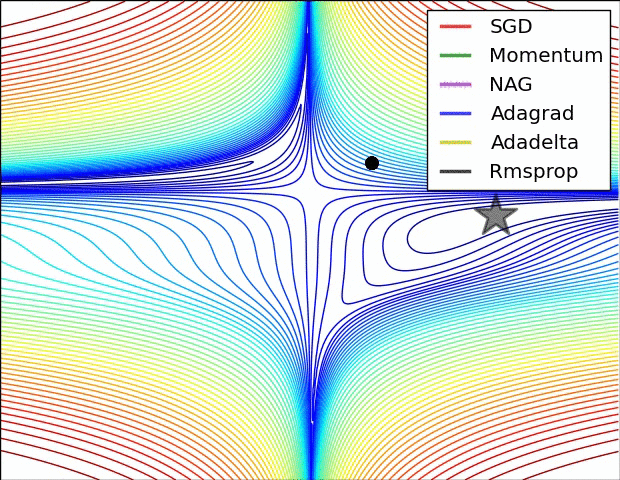

**Learning Rate**

TODO(Eñaut): https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html?highlight=learning%20rate#learning-rate




**Sources:**

- [ML Glossary](https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html)
- [Interactive Visualization of Optimization Algorithms in Deep Learning](https://emiliendupont.github.io/2018/01/24/optimization-visualization/)
- [Optimizers in Machine Learning](https://medium.com/nerd-for-tech/optimizers-in-machine-learning-f1a9c549f8b4)

In [ ]:
optimizer = Adam(learning_rate=0.0001)

#### 4.3.5 Define Metrics

Esplikatu

In [ ]:
metrics = [
    BinaryAccuracy(),
    Precision(),
    Recall(),
    BinaryIoU()
]

#### 4.3.6 Define Callbacks

Esplikatu

In [ ]:
callbacks = (lambda fold: [
    EarlyStopping(monitor="val_binary_io_u", patience=10, verbose=1, mode="max", restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=int(1e-6), verbose=1),
    ModelCheckpoint(MODEL_DIR + str(fold) + "_" + MODEL_NAME, monitor="val_binary_io_u", verbose=1, save_best_only=True, mode="max"),
])

#### 4.3.7 Define Histories List

In [ ]:
histories = []

#### 4.3.8 Train and Evaluate Each Fold

In [40]:
for fold, (train_index, validation_index) in enumerate(kfold.split(train_dataset)):
    # Split train-test
    train_set, validation_set = train_dataset.iloc[train_index], train_dataset.iloc[validation_index]
    
    # Create data generators for train and validation sets
    train_generator = DataGenerator(train_set, ["images"], "masks", BATCH_SIZE)
    validation_generator = DataGenerator(validation_set, ["images"], "masks", BATCH_SIZE)

    # Compile model
    unet_model.compile(optimizer=optimizer, 
                       loss=loss, 
                       metrics=metrics)

    # Train and save history
    histories.append(unet_model.fit(x=train_generator,
                                    validation_data=validation_generator,
                                    epochs=EPOCHS,
                                    steps_per_epoch=len(train_generator),
                                    callbacks=callbacks(fold)))
    
    # Clean Up
    gc.collect()

### 4.4 Display History

#### 4.4.1 Plot Histories 

In [ ]:
for j, history in enumerate(histories):
    keys = history.history.keys()
    fig, axs = plt.subplots(1, len(keys) // 2, figsize=(25, 5))
    fig.suptitle(str(j + 1) + " Fold Results", fontsize=30)
    for k, key in enumerate(list(keys)[:len(keys) // 2]):
        axs[k].plot(range(1, len(history.history[key]) + 1), history.history[key], "g--")
        axs[k].plot(range(1, len(history.history[key]) + 1), history.history["val_" + key], "b-")
        if key == "loss":
            axs[k].plot(np.argmin(history.history["val_" + key]), np.min(history.history["val_" + key]), marker='x', color='r')
        else:
            axs[k].plot(np.argmax(history.history["val_" + key]), np.max(history.history["val_" + key]), marker='x', color='r')
        axs[k].legend(["Training " + key, "Validation " + key, "Best Model"])
    plt.show()

#### 4.4.2 Clean Up

In [ ]:
gc.collect()

## 5 Test Model

### 5.1 Set Up

#### 5.1.1 Reset Index of the Test Dataset

In [16]:
test_dataset.reset_index(drop=True, inplace=True)

#### 5.1.2 Create Test Generator

In [17]:
test_generator = DataGenerator(test_dataset, ["images"], "masks", BATCH_SIZE)

#### 5.1.3 Set Results List

In [ ]:
results = []

### 5.2 Evaluate and Load

#### 5.2.1 Load and Evaluate Folds

In [ ]:
for fold in range(NUM_FOLDS):
    unet_model: Any | Model = load_model(MODEL_DIR + str(fold) + "_" + MODEL_NAME)
    evaluation = unet_model.evaluate(test_generator)
    results.append(dict(zip(unet_model.metrics_names, evaluation)))

#### 5.2.2 Print Results

##### 5.2.2.1 Fold Results

In [ ]:
for j, result in enumerate(results):
    print('*' * shutil.get_terminal_size().columns)
    print(f"{j + 1} Fold Results")
    for key, value in result.items():
        print(f"{key}: {value}")

##### 5.2.2.2 Model Results

In [ ]:
print('*' * shutil.get_terminal_size().columns)
for metric in unet_model.metrics_names:
    average = np.mean(np.fromiter((result[metric] for result in results), np.float64))
    print("Average {metric}: {average}")

#### 5.2.3 Clean Up

In [ ]:
gc.collect()

### 5.3 Select the Best Model

#### 5.3.1 Select Model

In [ ]:
selected_model = np.argmax(np.fromiter((result["binary_io_u"] for result in results), np.float64))
print(f"{int(selected_model) + 1} Fold Selected")

#### 5.3.2 Rename Model

In [ ]:
os.rename(MODEL_DIR + str(selected_model) + "_" + MODEL_NAME, MODEL_DIR + MODEL_NAME)

#### 5.3.3 Load Model

In [18]:
unet_model: Any | Model = load_model(MODEL_DIR + MODEL_NAME)

#### 5.3.4 Delete Other Models

In [ ]:
for model in os.listdir(MODEL_DIR):
    if model != MODEL_NAME:
        os.remove(os.path.join(MODEL_DIR, model))

#### 5.3.5 Clean Up

In [ ]:
gc.collect()

### 5.4 Visual Evaluation

#### 5.4.1 Predict

In [19]:
predictions = unet_model.predict(test_generator)

2024-01-16 17:04:56.655228: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-16 17:04:56.979791: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-16 17:05:07.017996: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-16 17:05:07.932094: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  1/197 [..............................] - ETA: 43:03

2024-01-16 17:05:09.103647: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


197/197 [==============================] - 104s 464ms/step


2024-01-16 17:06:40.627869: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 206569472 exceeds 10% of free system memory.


#### 5.4.2 Plot Images

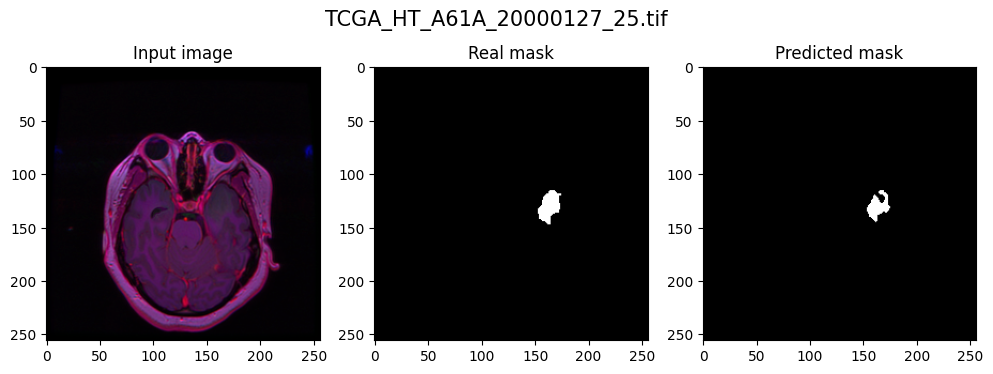

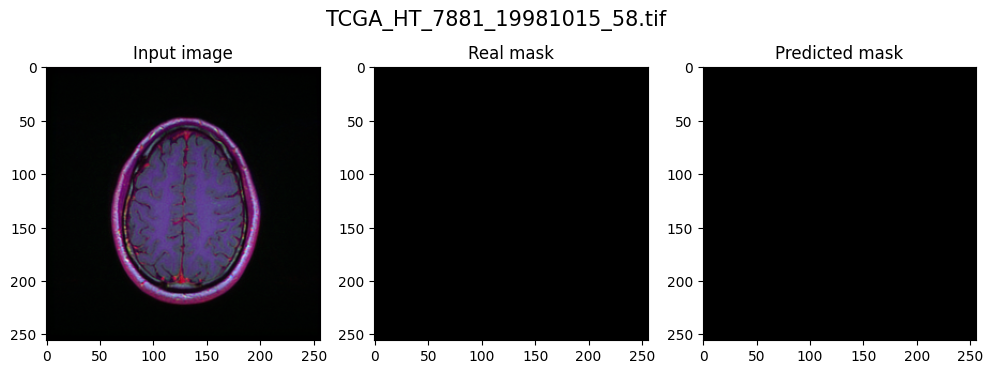

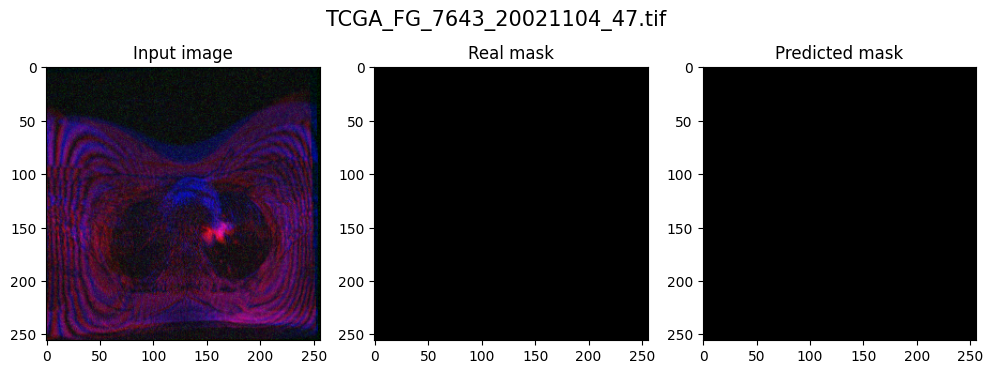

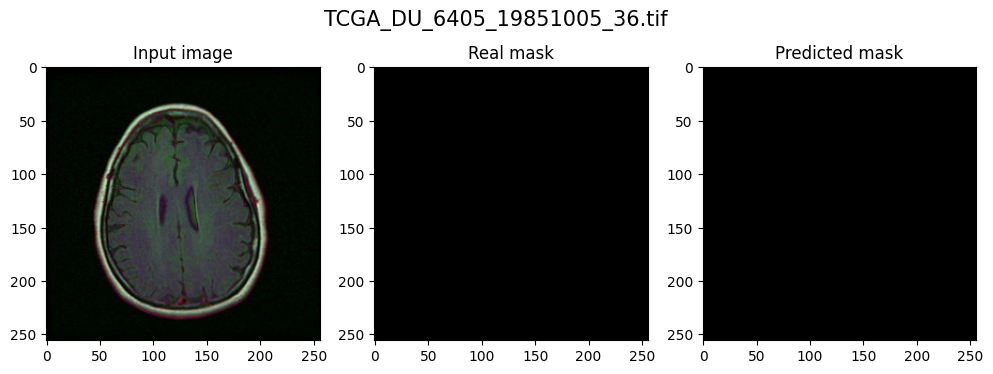

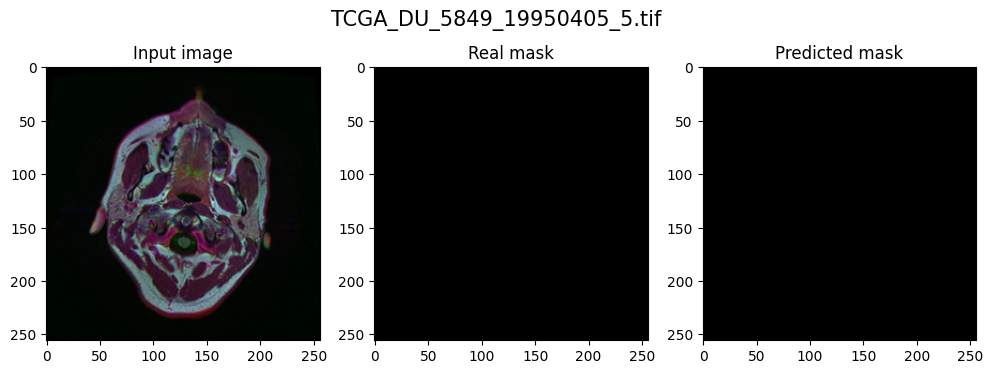

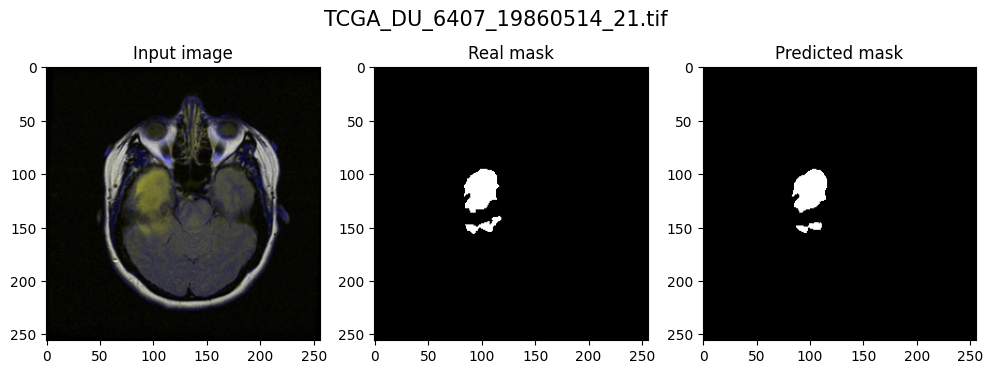

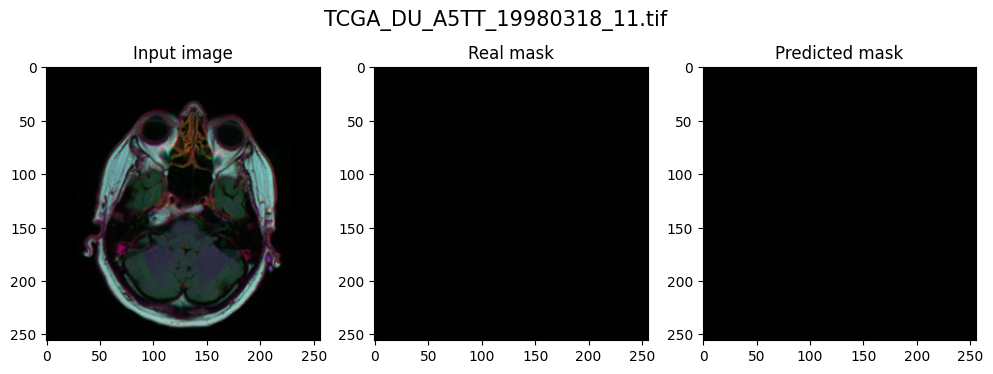

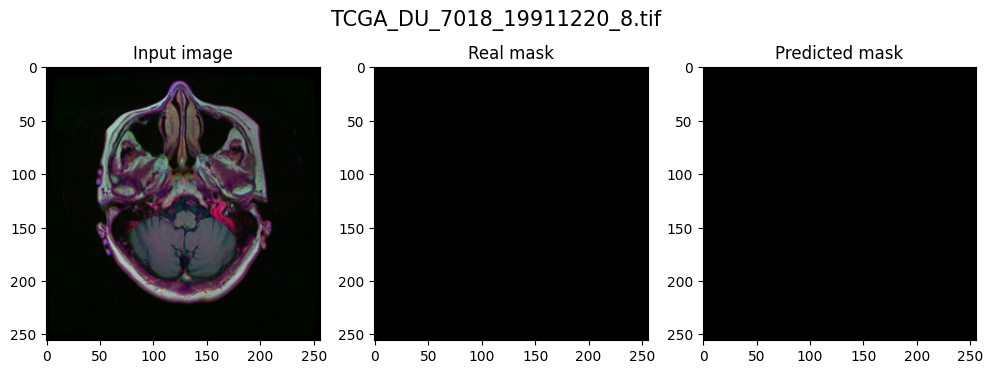

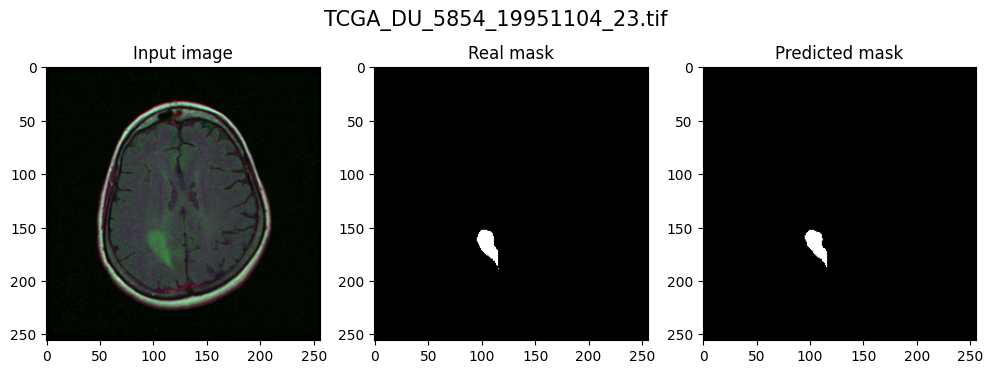

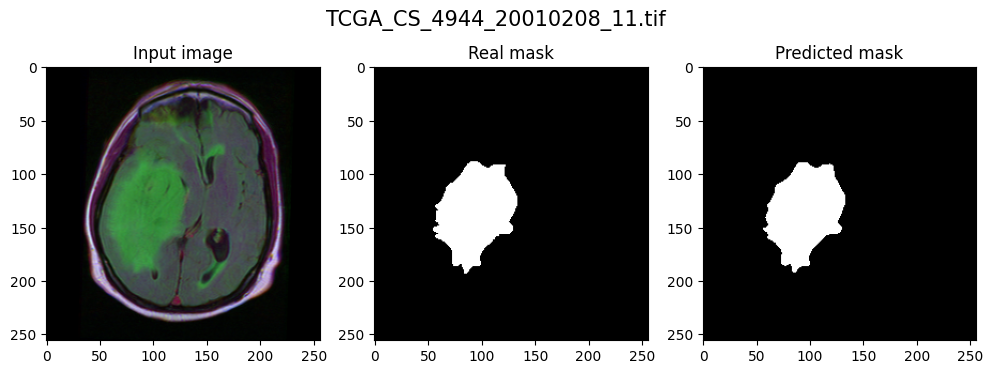

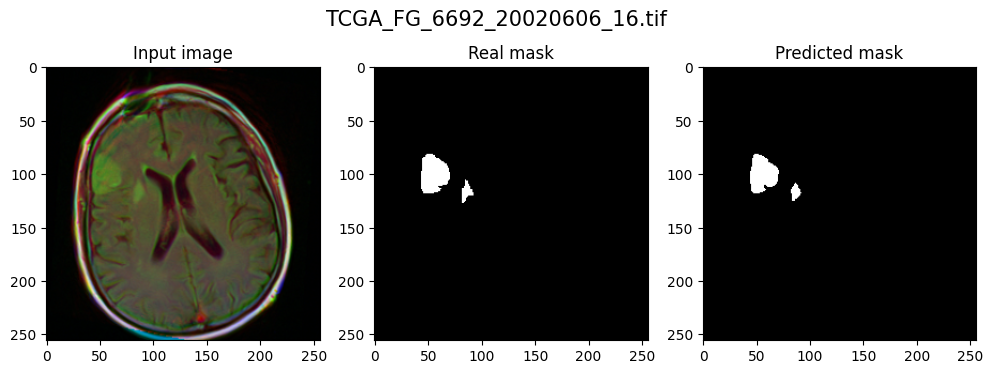

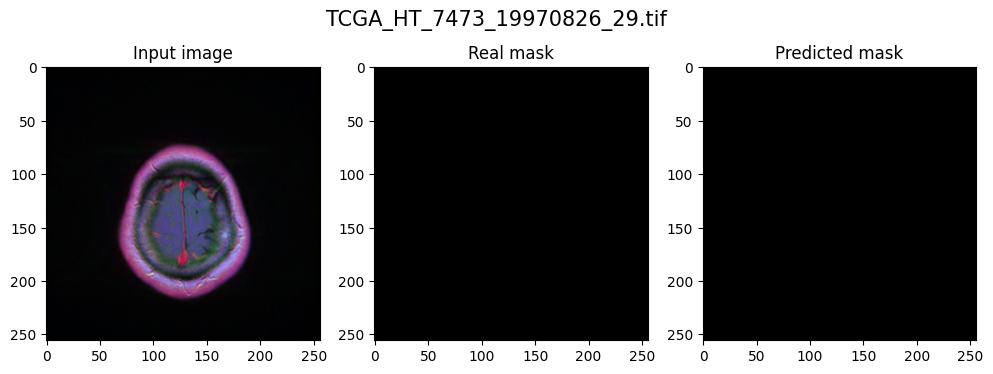

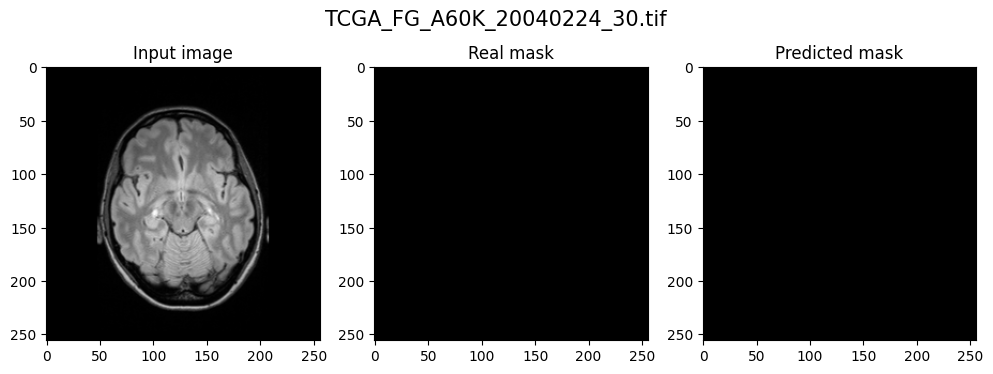

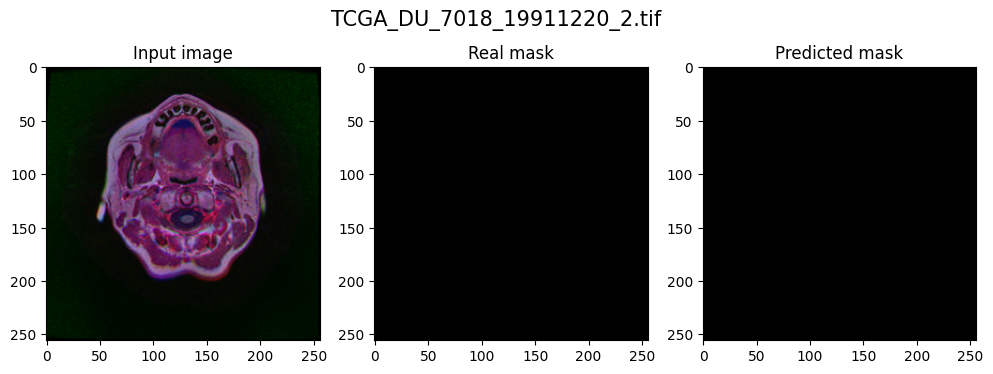

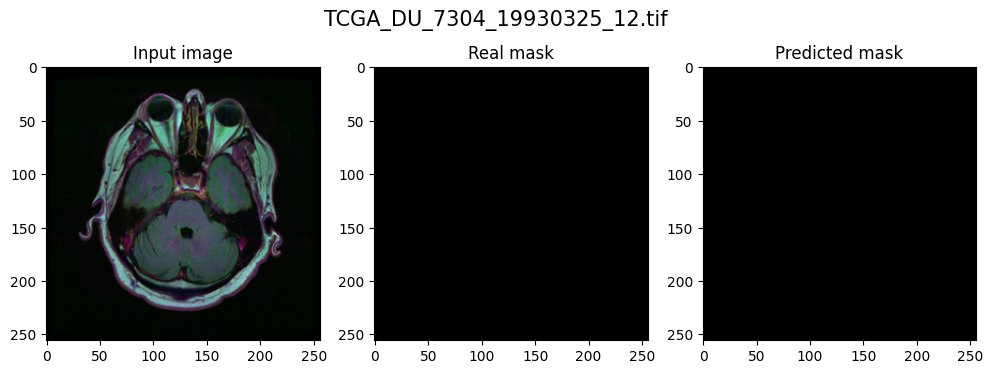

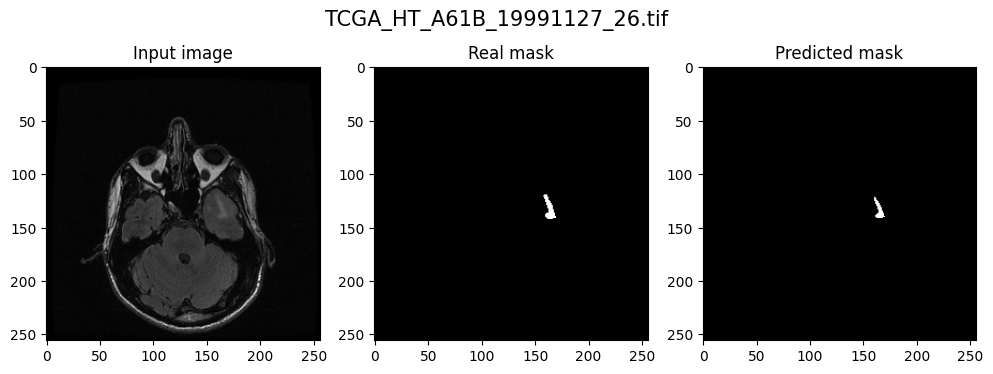

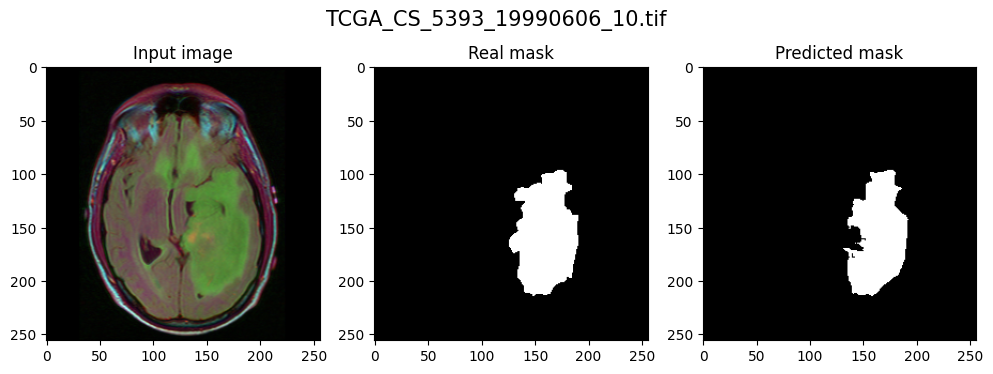

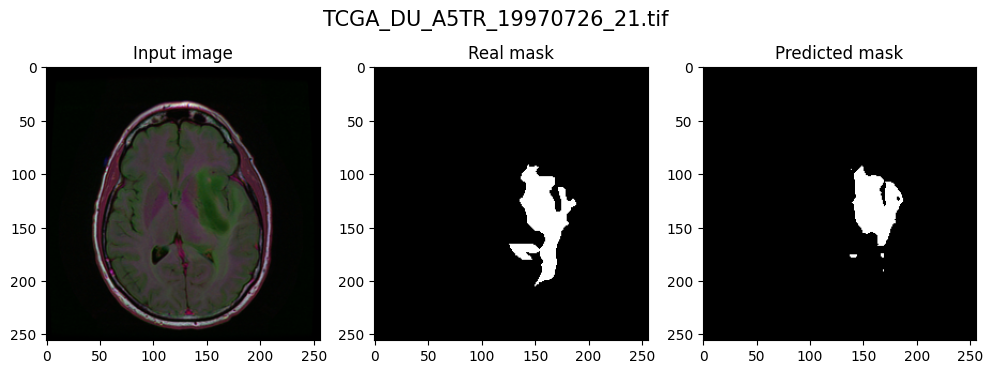

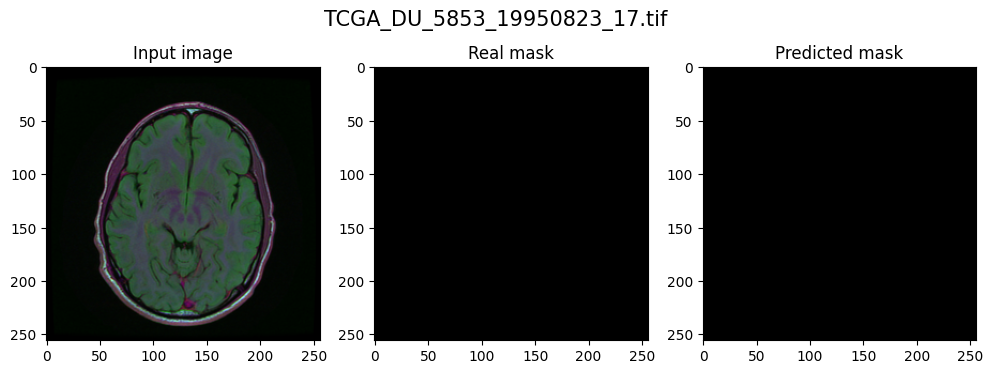

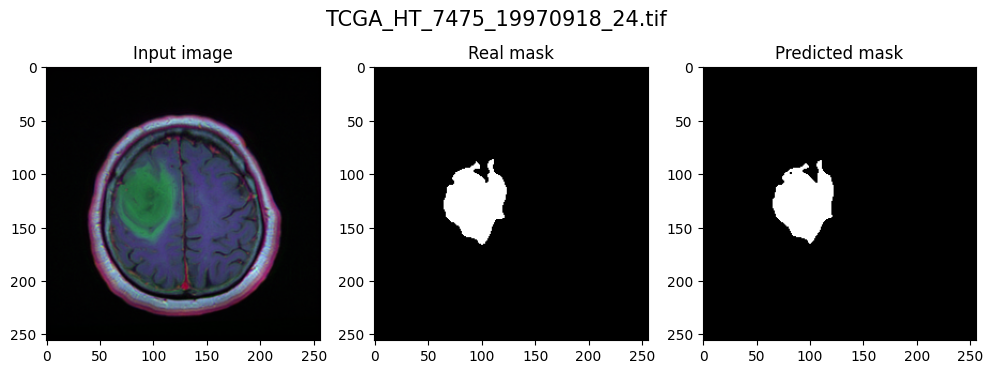

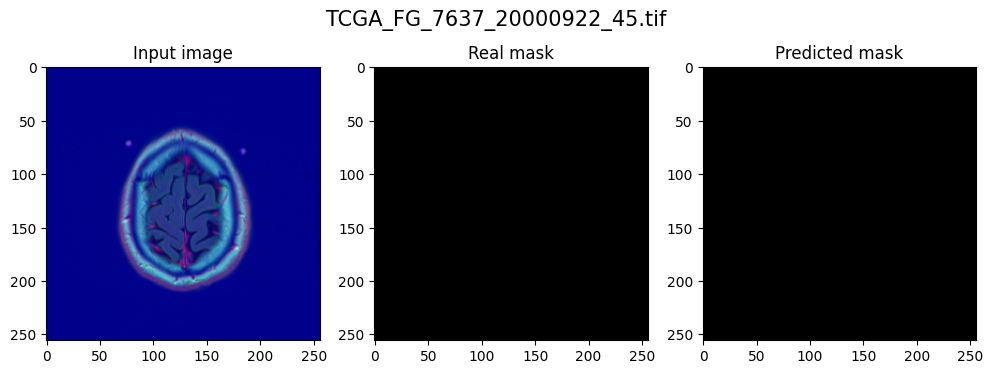

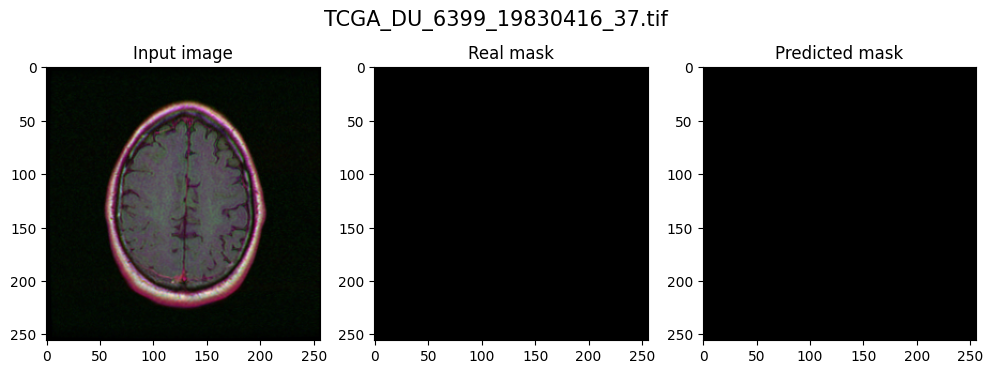

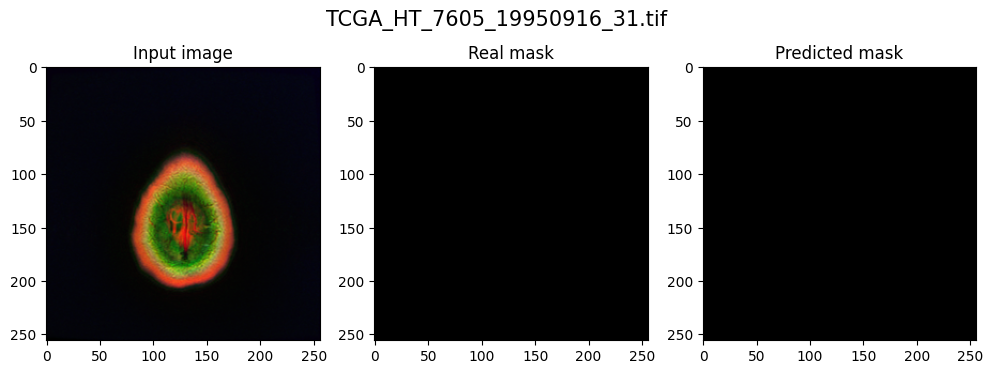

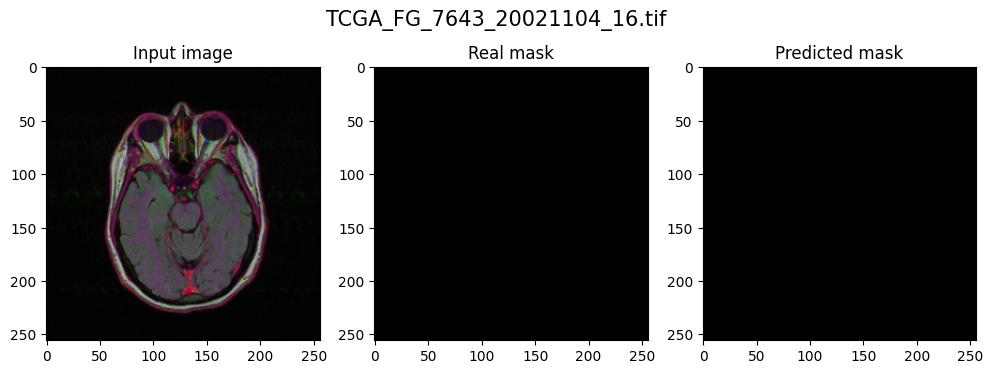

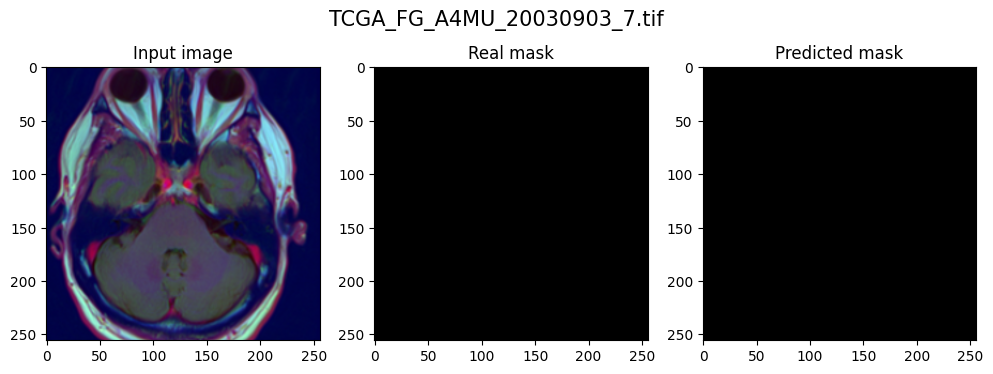

In [21]:
for _ in range(25):
    random_row: pd.DataFrame = test_dataset.sample()
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(random_row["image_names"].values[0], fontsize=15)
    for j, (ax, title) in enumerate(zip(axes, ["Input image", "Real mask", "Predicted mask"])):
        if j == 0:
            ax.imshow(random_row["images"].values[0])
        elif j == 1:
            ax.imshow(random_row["masks"].values[0], cmap="gray")
        else:
            ax.imshow(predictions[random_row.index].squeeze() > 0.95, cmap="gray")
        ax.set_title(title)
    plt.show()

#### 5.4.3 Clean Up

In [ ]:
gc.collect()